In [2]:
# coding: utf-8
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Softmax

## 编码器的改进

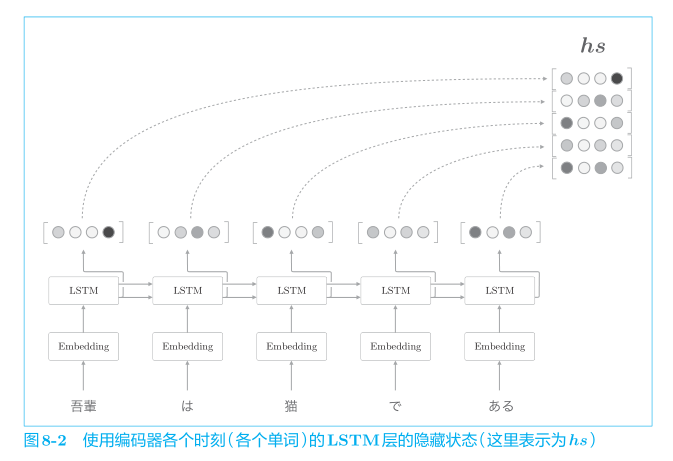

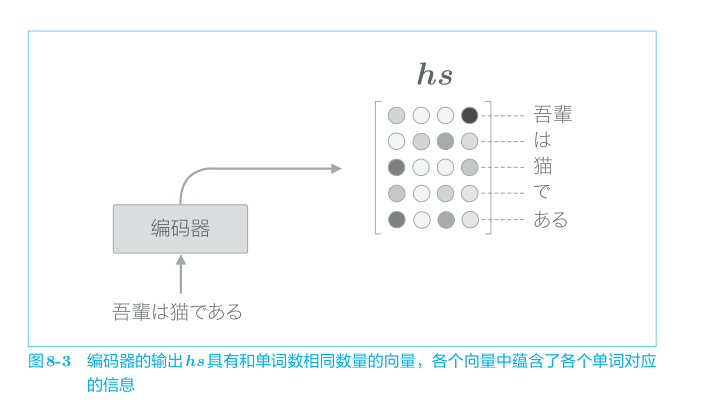

## 解码器的改进

### 解码器的改进1

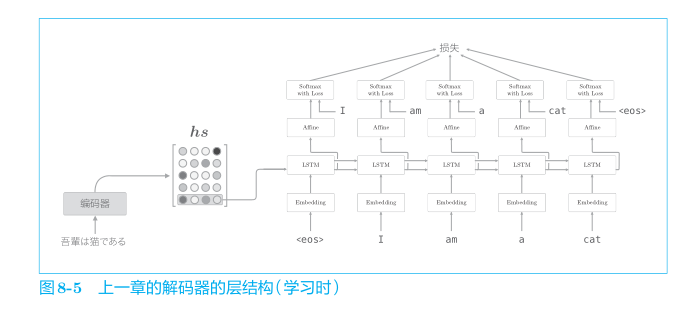

在机器翻译的历史中，很多研究都利用“猫 =cat”这样的单词对应关系的知识。这样的表示单词（或者词组）对应关系的信息称为对齐（alignment）。到目前为止，对齐主要是手工完成的，而我们将要介绍的 Attention 技术则成功地将对齐思想自动引入到了 seq2seq 中。这也是从“手工操作”到“机械自动化”的演变

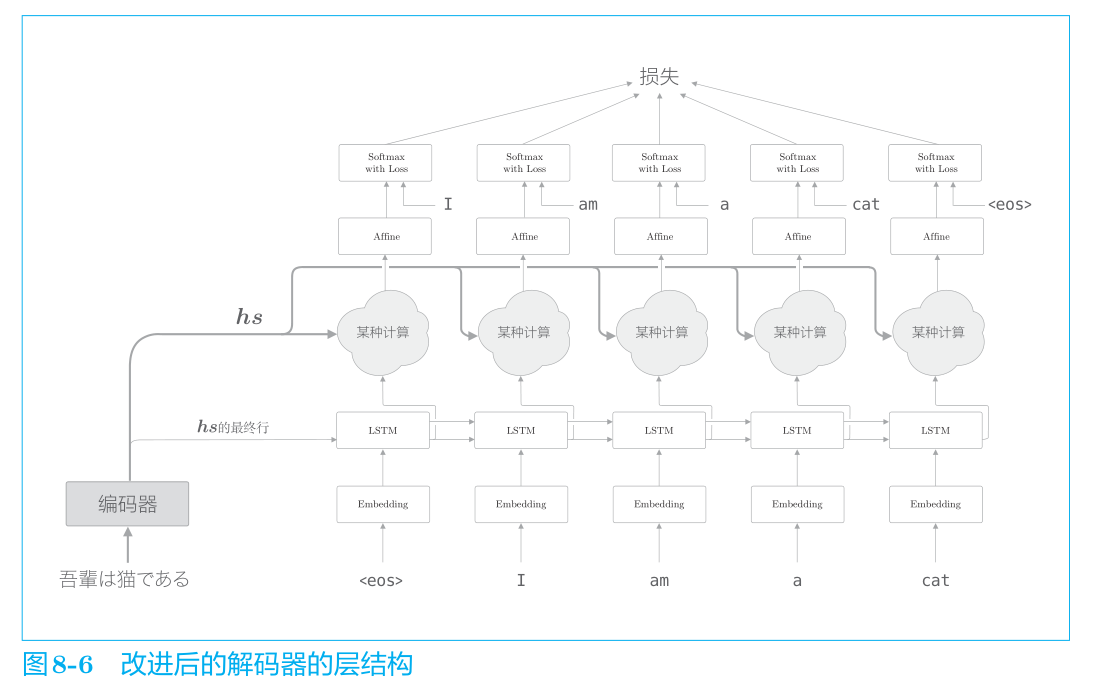

我们新增一个进行“某种计算”的层。这个“某种计算”接收（解码器）各个时刻的 LSTM 层的隐藏状态和编码器的 hs。然后，从中选出必要的信息，并输出到 Affine 层。与之前一样，编码器的最后的隐藏状态向量传递给解码器最初的 LSTM 层。

所做的工作是提取单词对齐信息。具体来说，就是从 hs中选出与各个时刻解码器输出的单词有对应关系的单词向量。

**不过这里有个问题，就是选择（从多个事物中选取若干个）这一操作是无法进行微分的**

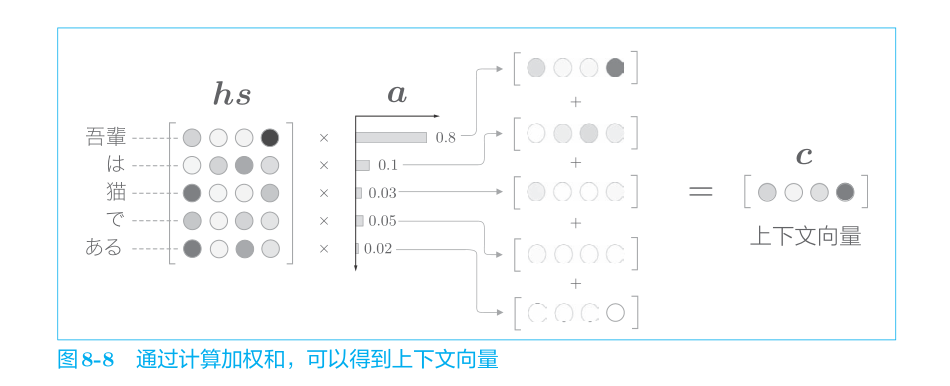

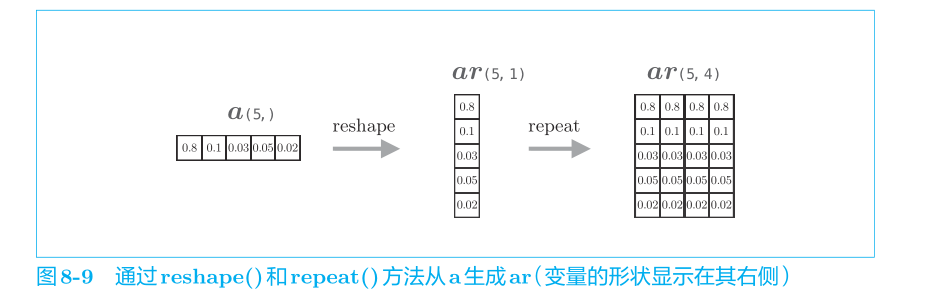

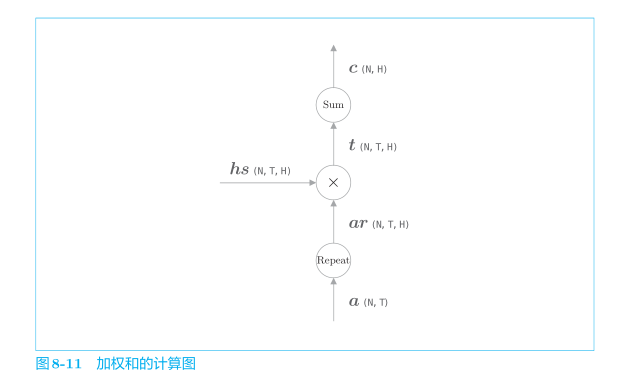

In [1]:
class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1).repeat(H, axis=2)
        t = hs * ar
        c = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.reshape(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)

        return dhs, da

### 解码器的改进2

如何求得表示各个单词重要度的权重a？

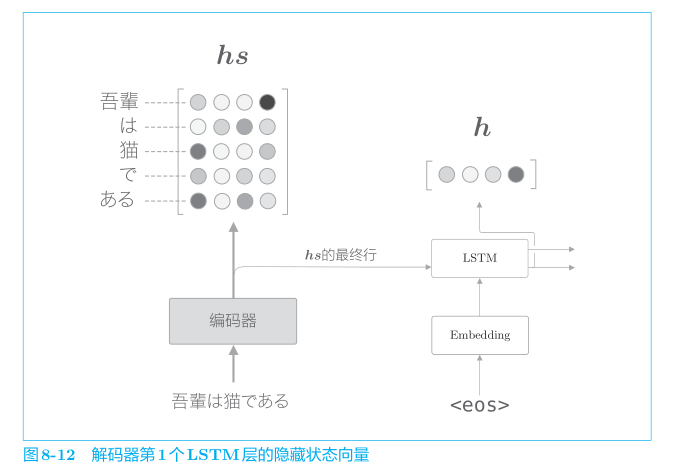

此时，我们的目标是用数值表示这个 h 在多大程度上和 hs 的各个单词向量“相似”。

通过向量内积

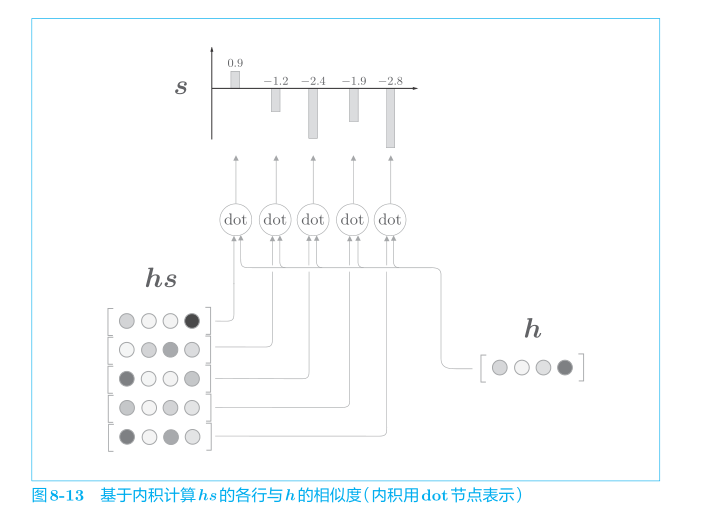

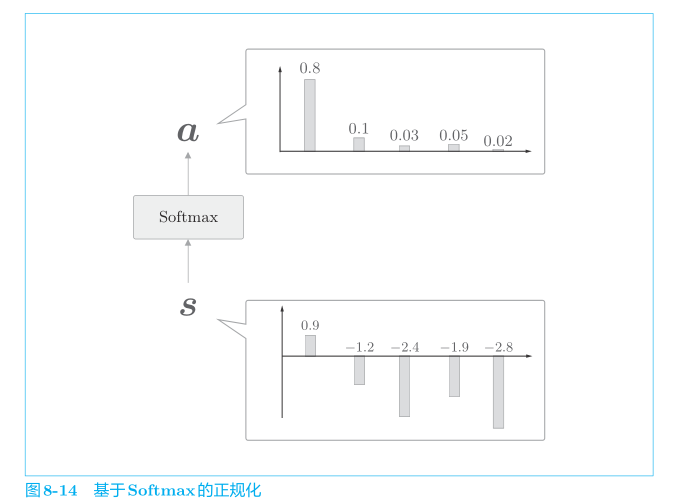

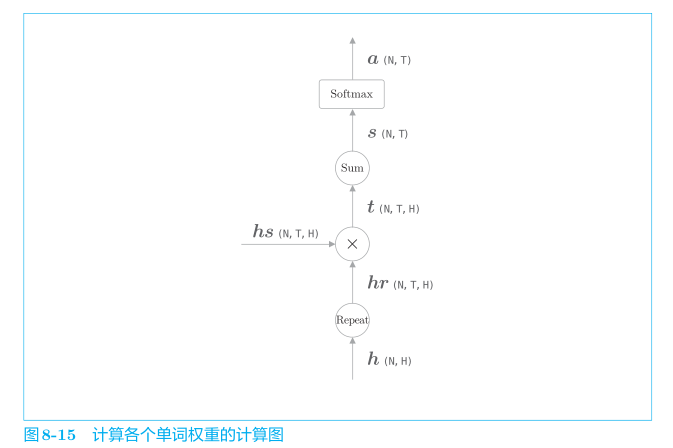

In [3]:
class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H).repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh

### 解码器的改进3

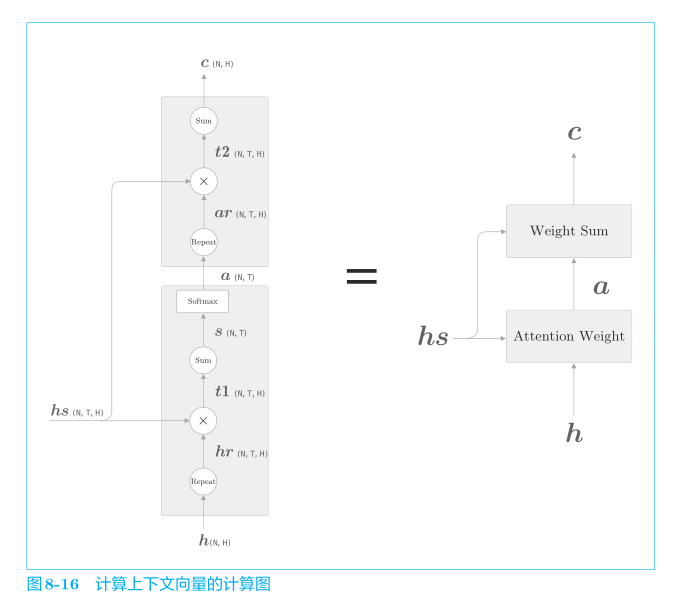

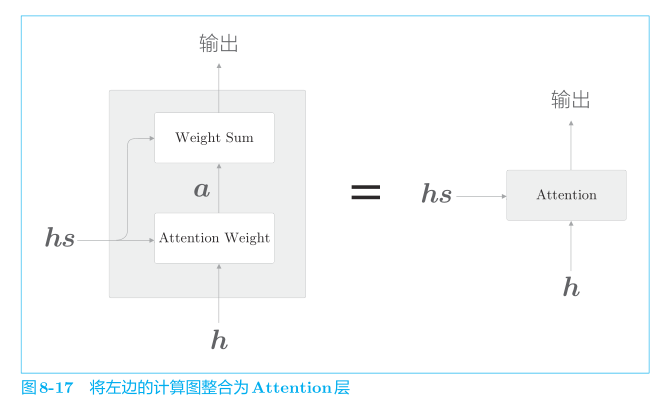

In [4]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh

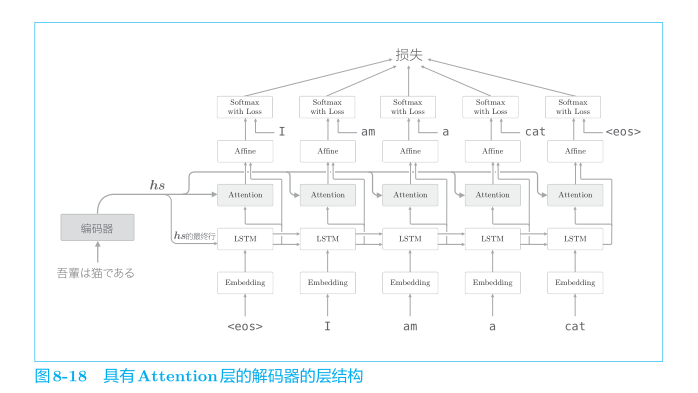

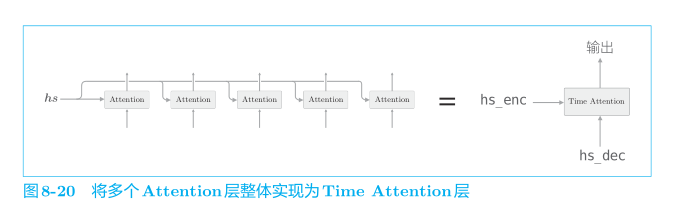

In [5]:
class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        N, T, H = hs_dec.shape
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weights = []

        for t in range(T):
            layer = Attention()
            out[:, t, :] = layer.forward(hs_enc, hs_dec[:,t,:])
            self.layers.append(layer)
            self.attention_weights.append(layer.attention_weight)

        return out

    def backward(self, dout):
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
            layer = self.layers[t]
            dhs, dh = layer.backward(dout[:, t, :])
            dhs_enc += dhs
            dhs_dec[:,t,:] = dh

        return dhs_enc, dhs_dec

## attetion的可视化

见visualize_attention

## 其他使用例子

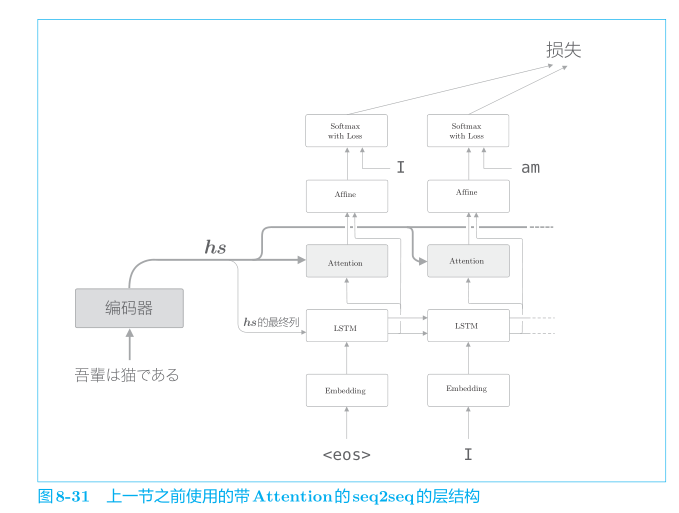

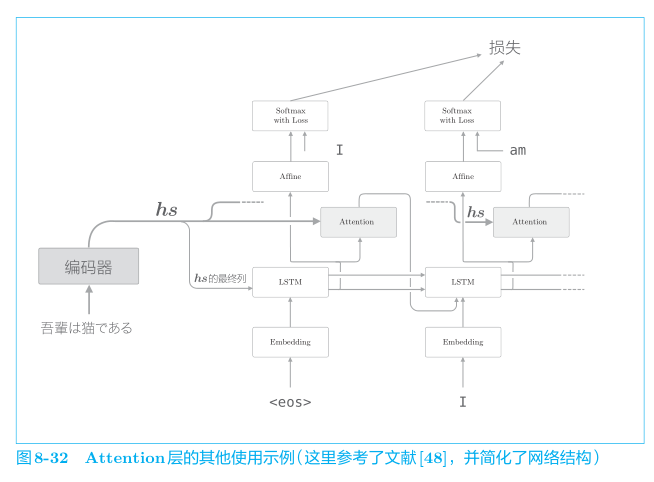

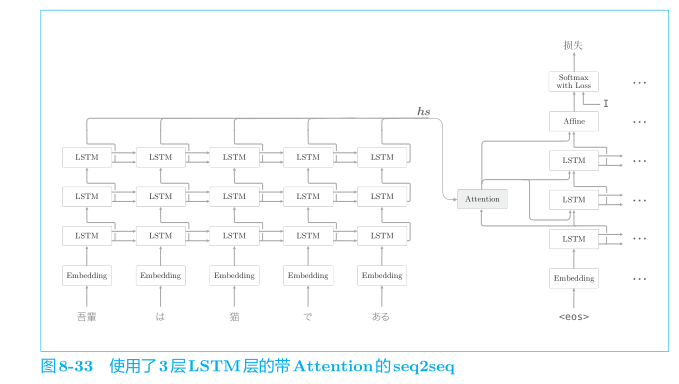